Ref: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [1]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [8]:
excludes_sites = ['Boskednan,']
excludes_features = ['other']

df = pd.read_csv(
    "data_clean.csv",
    index_col=0,
    )
df = df.fillna(0)
df = df.replace(['y', 'Y', '?'], [1, 1, 0.5])
df = df.astype(int)
# df = df.sort_index()
df.index = df.index.str.strip()
df = df[~df.index.isin(excludes_sites)]
df = df[df.columns[~df.columns.isin(excludes_features)]]
df

,standing stones/bouldrers,orthostats/boulders and bank,ditch and bank,bank,stones on or protrude from mound,"other, inc once below mound",regularly spaced,irregularly spaced,contiguoius,bank faced inside,...,more than one mehir outside,arc outside,paired stones outside,avenue row,other exterior,part of complex,diam 1,diam 2,diam 3,diam 4
"Cerrig Pryfraid , |Gwyb",1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
Brankam Hill 2 Angus,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
"Upper Auchnagorth, Aber",1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
"Abercross, High",1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
"Achanarass Hill, Highlands",1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"White Moss NE, C",1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
"White Moss NW, C",1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
Winterbourne Bassett,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
"Woodside, P&K",1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [6]:
def plot_dendrogram_from_df(df, method):
    X = df.values
    Z = linkage(X, method=method)

    c, coph_dists = cophenet(Z, pdist(X))

    plt.figure(figsize=(10, 25))
    plt.title(f'Hierarchical Clustering, {method} method\ncophenet: {c:.2f}')
    plt.xlabel('Distance')
    plt.ylabel('Site')
    dendrogram(
        Z,
        orientation='right',
        leaf_font_size=8.,  # font size for the x axis labels,
        labels=df.index,
        truncate_mode='level',
        p=4
    )
    plt.savefig(f"clustering - {method}.png")
    return Z

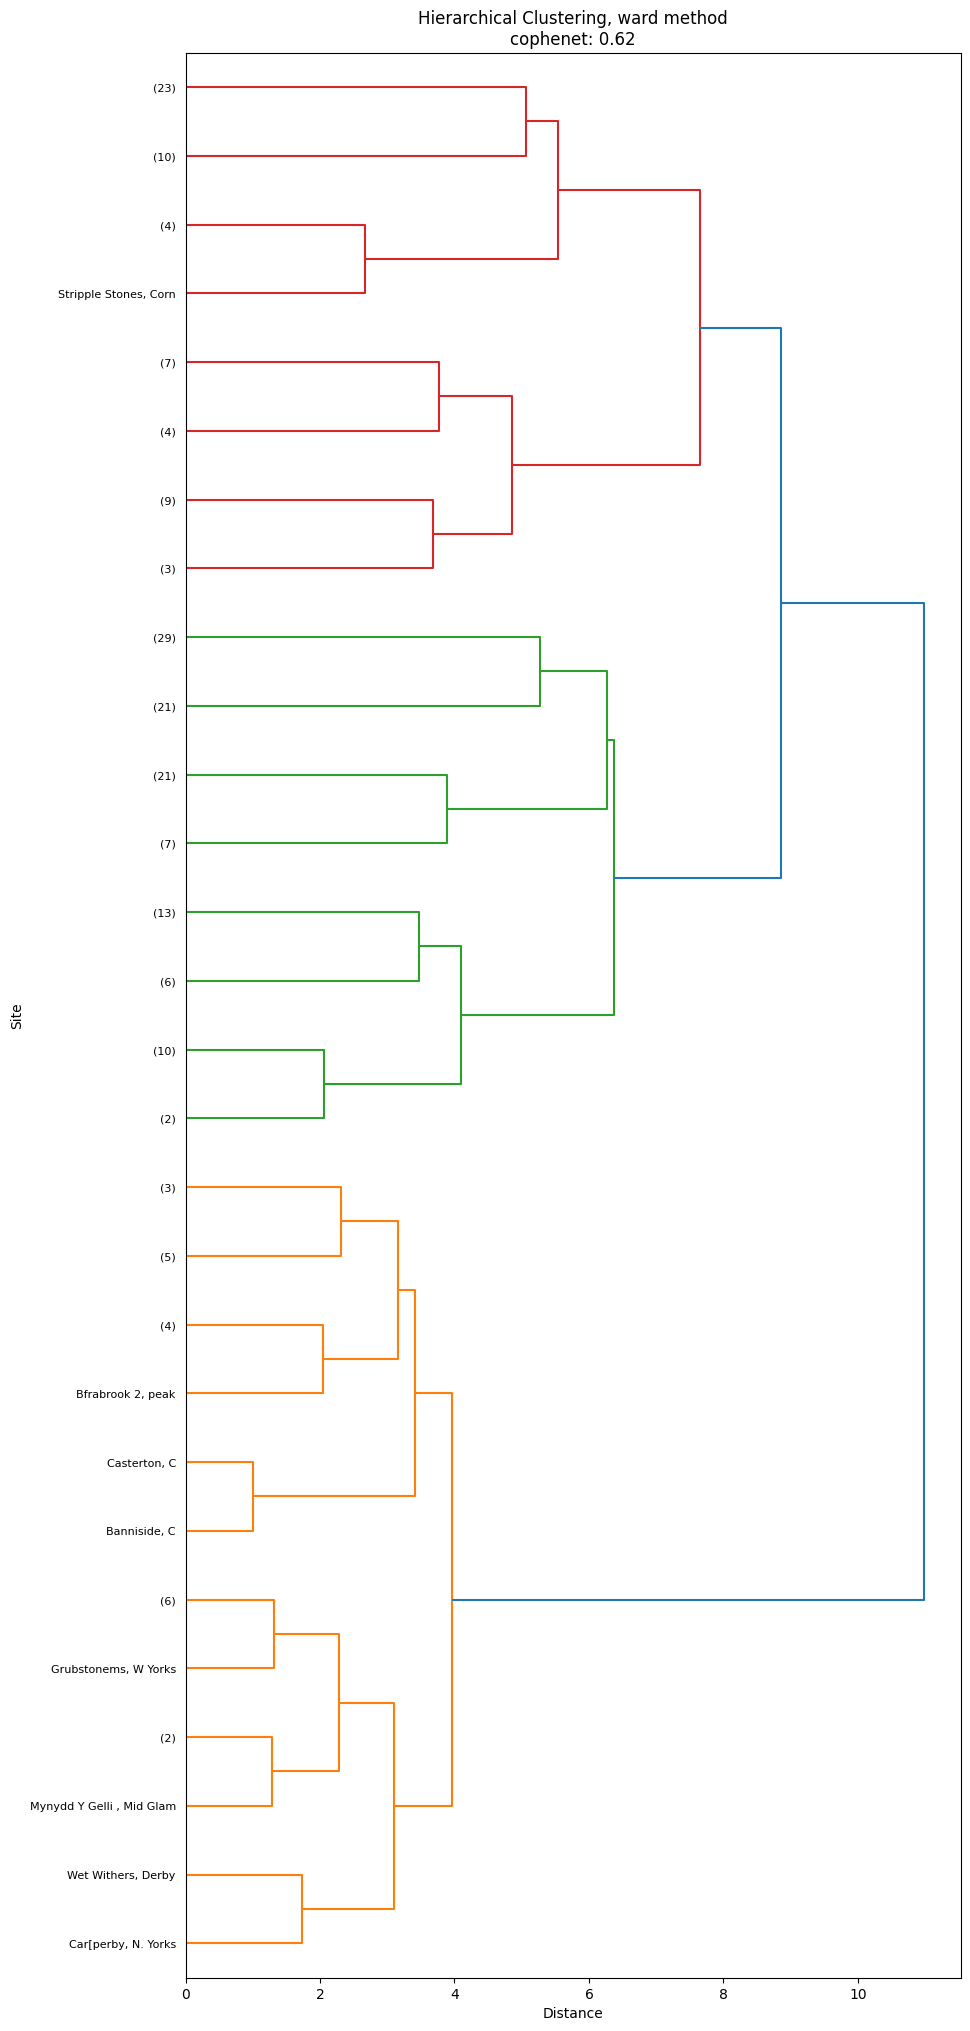

In [9]:
methods = [
    # 'single',
    # 'complete',
    # 'average',
    # 'weighted',
    # 'centroid',
    # 'median',
    'ward'
    ]

linkages = {method: plot_dendrogram_from_df(df, method) for method in methods}

In [11]:
n_clusters = 4
n_features = 10

L = linkages['ward']
df['clusters'] = fcluster(L, n_clusters, criterion='maxclust')
df.clusters = df.clusters.astype(str)  # for categorical plot labels

group_data = df.groupby('clusters').mean()

# compute difference metric
metric_df = group_data.apply(lambda row: abs(group_data.iloc[group_data.index != row.name] - row).min(), axis=1)

# get top 10 columns by highest difference metric
col_order = metric_df.max().T.sort_values(ascending=False).index
col_order = col_order[:n_features]

# reorder by value for cluster
# group_data = group_data[col_order]
# col_order = group_data.T.sort_values(by=['1'], ascending=False).index
metric_df = metric_df[col_order]
group_data = group_data[col_order]

fig = px.imshow(group_data, color_continuous_scale='greys')
fig.update_layout(title='Average value in cluster')
fig.show()
fig = px.imshow(metric_df, color_continuous_scale='greys')
fig.update_layout(title='Difference metric')
fig.show()

In [44]:
desc_df = group_data[metric_df > 0.4]
desc_df = desc_df.dropna(how='all', axis=1)
desc_df = desc_df.round()
# cluster_descs = desc_df.apply(lambda row: )
desc_df

,orthostats/boulders and bank,bank faced inside,standing stones/bouldrers,regularly spaced,diam 1
clusters,,,,,
1,1.0,1.0,0.0,NaN,NaN
2,NaN,NaN,NaN,1.0,NaN
3,NaN,NaN,NaN,NaN,1.0
